In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import sklearn.model_selection as ms
import matplotlib.pyplot as plt
from sklearn import metrics

In [2]:
Auto = pd.read_csv("data/Auto.csv",header=0, na_values='?').dropna()
Auto.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
0,18.0,8,307.0,130.0,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150.0,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140.0,3449,10.5,70,1,ford torino


In [3]:
X_auto = np.array(Auto.drop(['mpg', 'name'], axis=1))
Y_auto = np.array(Auto[['mpg']])

In [8]:
X_mean_auto = np.reshape((X_auto.mean(0)), (-1,7))
X_range_auto = np.zeros((7,1))
for i in range(7):
    X_range_auto[i] = np.amax(X_auto[:,i]) - np.amin(X_auto[:,i])
X_range_auto = np.transpose(X_range_auto)
X_stand_auto = (X_auto - X_mean_auto) / X_range_auto
n_auto = np.shape(X_stand_auto)[0]
X_auto_d = np.c_[np.ones(n_auto), X_stand_auto]

For this project, we are using gradient descent and stochastic gradient descent to obtain estimates of our regression coefficients. Lets start by training our linear regression.

In [9]:
lm_auto = sm.OLS(Y_auto, X_auto_d)
results = lm_auto.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.821
Model:                            OLS   Adj. R-squared:                  0.818
Method:                 Least Squares   F-statistic:                     252.4
Date:                Sat, 11 Jun 2022   Prob (F-statistic):          2.04e-139
Time:                        15:48:56   Log-Likelihood:                -1023.5
No. Observations:                 392   AIC:                             2063.
Df Residuals:                     384   BIC:                             2095.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         23.4459      0.168    139.498      0.0

0.818 is pretty high r-squared for any data. Looking at the sumamry, we can see that 5 of the coefficients are significant and 3 are not. The 3 that are not are Cylinders, Horsepower, and Acceleration. Lets start the gradient descent.

In [11]:
theta = np.random.randn(8,1)

def computeCost(X, y, theta):
    inner = np.power(((X.dot(theta)) - y), 2)
    return np.sum(inner) / (2 * len(X))

cost = list()
iteration = 0
error = 1
eta = 0.001
while error > 0.0001:
    gradients = 2/n_auto * X_auto_d.T.dot(X_auto_d.dot(theta) - Y_auto)
    theta = theta - eta * gradients
    cost.append(computeCost(X_auto_d, Y_auto, theta))
    if iteration > 0:
        error = cost[iteration-1] - cost[iteration]
    iteration += 1

[[23.44591119]
 [-6.51031901]
 [-2.57682381]
 [-2.99452387]
 [-5.00728258]
 [ 0.66066396]
 [ 6.76975564]
 [ 3.9173164 ]]


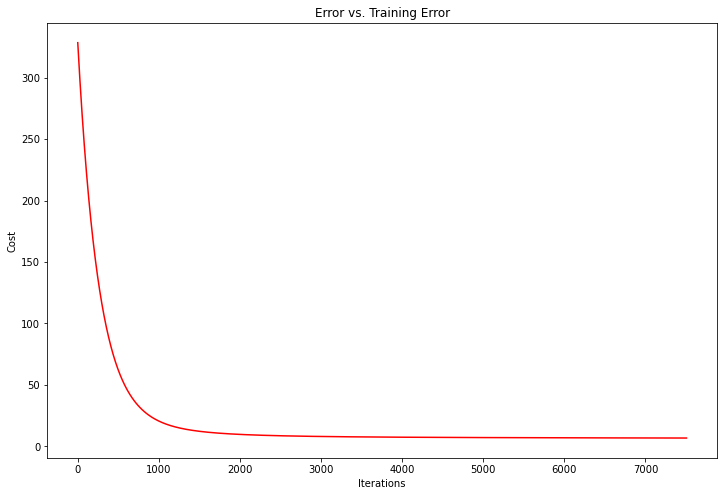

In [12]:
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(np.arange(iteration), cost, 'r')
ax.set_xlabel('Iterations')
ax.set_ylabel('Cost')
ax.set_title('Error vs. Training Error')
print(theta)

After about 2500 iterations, our cost was reduced as much as it could be. We can also see that some of the regression coefficients are different that what is returned with OLS regression. This is because gradient descent should be used for predictive modeling, not inferential modeling. Theoretically, we could run this again with a different random sampling, and get different coefficients.

Lets compare gradient descent to stochastic gradient descent.

In [13]:
shuffle = pd.concat((pd.DataFrame(X_auto_d), pd.DataFrame(Y_auto)),1)
shuffle = np.array(shuffle.sample(frac=1))
shuffle_x = shuffle[:,0:8]
shuffle_y = shuffle[:,8:9]

First we had to put our x and y variables back together so we could randomly shuffle them the same way, and then pull them back apart.

In [14]:
cost_sgd = list()
iteration_sgd = 0
error_sgd = 1
eta_sgd = 5
theta_sgd = np.random.randn(8,1)
for i in range(np.shape(shuffle_x)[0]):
    gradients_sgd = np.reshape(1/n_auto * shuffle_x.T[:,i] * (shuffle_x[i,:].dot(theta_sgd) - shuffle_y[i,:]), (8,1))
    theta_sgd = theta_sgd - eta_sgd * gradients_sgd
    cost_sgd.append(computeCost(shuffle_x,shuffle_y,theta_sgd))
    if iteration_sgd > 0:
        error_sgd = cost_sgd[iteration_sgd-1] - cost_sgd[iteration_sgd]
    iteration_sgd += 1

[[23.53564709]
 [-5.82814085]
 [-3.51684916]
 [-2.12473653]
 [-3.72490075]
 [ 3.35475923]
 [ 3.67099685]
 [ 2.04850713]]


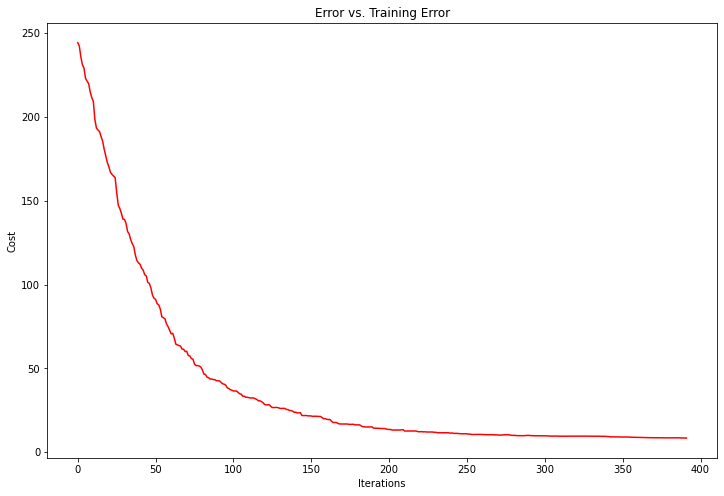

In [15]:
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(np.arange(iteration_sgd), cost_sgd, 'r')
ax.set_xlabel('Iterations')
ax.set_ylabel('Cost')
ax.set_title('Error vs. Training Error')
print(theta_sgd)

This takes less than 1/5 of the time to reduce its cost to the lowest it will go. You can see it is not a smooth curve this time, this is due to the random factor present in stochastic gradient descent. It is faster because it does not look over the entire dataset, just 1 sample at a time, out of a random sample of the dataset. Now we can directly compare eour coeficcients.

In [16]:
print(theta)
print(theta_sgd)

[[23.44591119]
 [-6.51031901]
 [-2.57682381]
 [-2.99452387]
 [-5.00728258]
 [ 0.66066396]
 [ 6.76975564]
 [ 3.9173164 ]]
[[23.53564709]
 [-5.82814085]
 [-3.51684916]
 [-2.12473653]
 [-3.72490075]
 [ 3.35475923]
 [ 3.67099685]
 [ 2.04850713]]


Some of the coefficients present are similar in both models and some differ. Gradient descent does not try to get the coefficients close to their true values, it just finds the most optimal coefficients for predictive analysis.